In [17]:
import pandas as pd
import numpy as np

!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup

import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium 

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Done!


## Functions that will be used later

In [18]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    # print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [20]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [21]:
ny_data.shape

(306, 4)

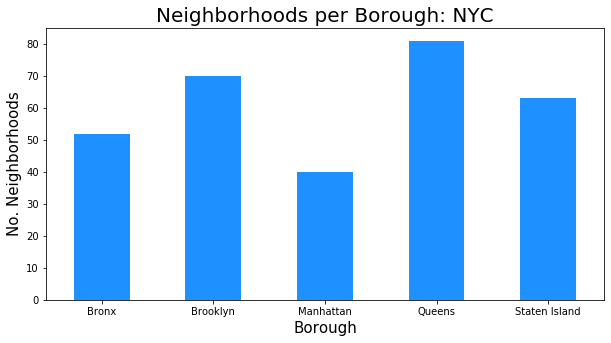

In [5]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

## Define Foursquare Credentials and Version

In [22]:
CLIENT_ID = 'JCE43MTWN5GQKFWEC4G2JWPZILDHMEFJ4RXVMJYT3A3ZGI3E' # your Foursquare ID
CLIENT_SECRET = '0LV4TS52P053A0Q20MB1DHASL2U31JLVJVUYHTBEJKWVOIDC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JCE43MTWN5GQKFWEC4G2JWPZILDHMEFJ4RXVMJYT3A3ZGI3E
CLIENT_SECRET:0LV4TS52P053A0Q20MB1DHASL2U31JLVJVUYHTBEJKWVOIDC


## Lets analyze further and see how many Chinese restaurants there are in each neighborhood and burough and graph the results.

In [23]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    #print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    #print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [24]:
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [26]:
chinese_rest_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
172,Queens,Middle Village,4e4dd064bd41b76bef938bdf,New China
173,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
174,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
175,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
176,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [27]:
chinese_rest_ny.shape

(177, 4)

#### As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it is one of the borough in NYC with the highest number if Chinese restaurants. The Queens has the highest number of Chinese restaurant. Also the neighborhood of Chinatown has the highest number of Chinese restaurants in all of NYC and is actually located in the borough of Manhattan.

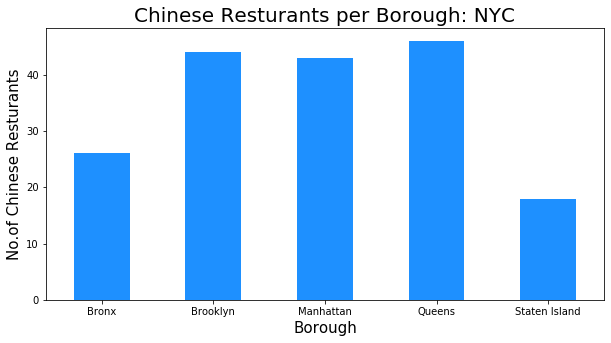

In [28]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

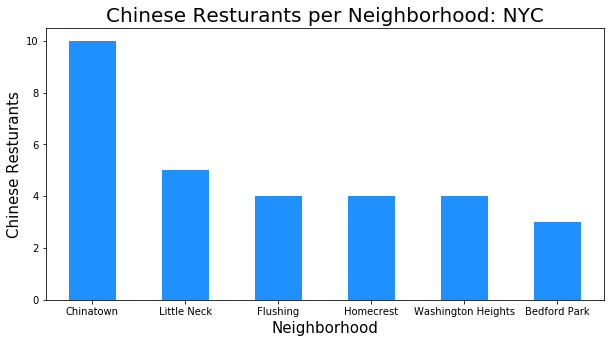

In [29]:
NOofNeigh = 6 # top six Neighborhood
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [30]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
55,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
56,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
57,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
58,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
59,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
60,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
61,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
62,Manhattan,Chinatown,49ff2ae8f964a520e66f1fe3,Famous Sichuan
63,Manhattan,Chinatown,4c7ab2ac2d3ba143bb1d92d0,Sun's Organic Tea Shop
64,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant


In [34]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
    #    print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        #print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    # print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
172,Queens,Middle Village,0,0,0,0,0
173,Staten Island,Prince's Bay,0,0,0,0,0
174,Bronx,Allerton,0,0,0,0,0
175,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.4,5
176,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.7,7


In [35]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [37]:
chinese_rest_stats_ny.shape

(177, 7)

In [38]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       177 non-null    object
 1   Neighborhood  177 non-null    object
 2   ID            177 non-null    object
 3   Name          177 non-null    object
 4   Likes         177 non-null    object
 5   Rating        177 non-null    object
 6   Tips          177 non-null    object
dtypes: object(7)
memory usage: 9.8+ KB


In [39]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       177 non-null    object 
 1   Neighborhood  177 non-null    object 
 2   ID            177 non-null    object 
 3   Name          177 non-null    object 
 4   Likes         177 non-null    float64
 5   Rating        177 non-null    float64
 6   Tips          177 non-null    float64
dtypes: float64(3), object(4)
memory usage: 9.8+ KB


In [40]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,177.000000,177.000000,177.000000
mean,51.096045,4.571186,19.000000
std,165.165952,3.649442,57.143957
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,6.400000,4.000000
75%,20.000000,7.700000,10.000000
max,1488.000000,9.200000,521.000000


In [41]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 83, dtype: object

In [42]:
# Resturant with maximum Ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                               9.2
Tips                                  10
Name: 88, dtype: object

In [43]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 83, dtype: object

In [44]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
74,North Side,8.90
16,Chelsea,8.80
69,Murray Hill,8.80
109,West Village,8.70
104,Upper West Side,8.60
102,Tribeca,8.50
45,Greenwich Village,8.45
30,East Village,8.40
113,Woodside,8.30
26,Downtown,8.30


In [45]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.695349
3,Queens,4.684783
1,Brooklyn,4.300000
0,Bronx,1.796154
4,Staten Island,1.488889


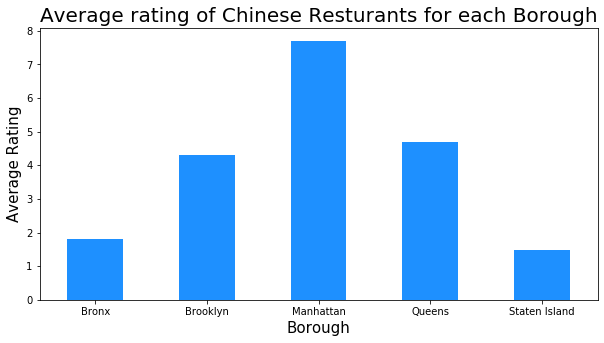

In [46]:
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Chinese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [47]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
9,Boerum Hill,8.000000
16,Chelsea,8.800000
17,Chinatown,8.040000
22,College Point,8.100000
26,Downtown,8.300000
30,East Village,8.400000
45,Greenwich Village,8.450000
57,Little Italy,8.033333
65,Midtown,8.000000
69,Murray Hill,8.800000


In [48]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.000000
1,Manhattan,Chelsea,40.744035,-74.003116,8.800000
2,Staten Island,Chelsea,40.594726,-74.189560,8.800000
3,Manhattan,Chinatown,40.715618,-73.994279,8.040000
4,Queens,College Point,40.784903,-73.843045,8.100000
5,Brooklyn,Downtown,40.690844,-73.983463,8.300000
6,Manhattan,East Village,40.727847,-73.982226,8.400000
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.450000
8,Manhattan,Little Italy,40.719324,-73.997305,8.033333
9,Manhattan,Midtown,40.754691,-73.981669,8.000000


In [49]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [50]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [51]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [52]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')